In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
import itertools
import random
from sklearn.metrics import accuracy_score
from sklearn.metrics import pairwise_distances_argmin
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
import sklearn as sk
from mnist import MNIST
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.stats import mode
import random

In [2]:
def label_with_delta(X,centers,delta): #give X (points) and centers: 2 numpy arrays
    labels = []
    count = 0 #to count the number of times we chose a random center
    for dist_array in pairwise_distances(X,centers): #dist_array is the array of distances between on element Xi of X and each cluster! 
        mindist = np.min(dist_array) #distance between Xi and its closest clusters
        normalmin = [np.argmin(dist_array)] # index of the clusters closest to Xi
        close_dist = set([dist for dist in dist_array if abs(dist-mindist)<delta]) #array of all distance of dist_array if they are delta-close to mindist 
        deltamin = [i for i, item in enumerate(dist_array) if item in close_dist] #index of delta-close centers 
        deltachoice = random.choice(deltamin) #choose randomly one of the delta-close centers
        labels.append(deltachoice)
        if deltamin!=normalmin:
            count+=1
    #print("DELTA K-MEANS: %d random choices of centers over %d"%(count,len(X)))
    return np.array(labels),count

def label_regular(X,centers):
    return pairwise_distances_argmin(X,centers)

def lossfunction(X,labels,centers):
    N = len(X)
    loss = 1/np.sqrt(N)*np.sum([np.linalg.norm(X[i]-centers[labels[i]]) for i in range(N)])
    return loss

In [3]:
#mndata = MNIST('/home/scinawa/workspace/hackedkit/python-mnist/data')
mndata = MNIST('/Users/Jonas/Desktop/EXPERIMENTS_DELTA_KMEANS/MNIST/MNIST_data')

X, y = mndata.load_training()

In [4]:
y = np.array(y)
X = np.array(X)

In [5]:
print("data: X of shape (number, dimension)={}".format(np.shape(X)))

data: X of shape (number, dimension)=(60000, 784)


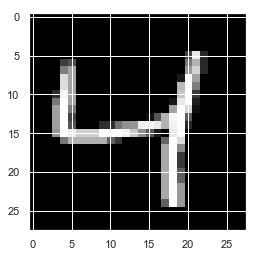

label: 4


In [6]:
def image_print(x):
    pixels = x.reshape((28, 28))
    plt.imshow(pixels, cmap='gray')
    plt.show()
    
image_print(X[2])
print("label: "+str(y[2]))

In [7]:
X = sk.preprocessing.normalize(X) #normalization

In [8]:
#Dimensional reduction: LDA
dimred = LinearDiscriminantAnalysis()
X_ = dimred.fit_transform(X, y)
print("data: X of shape (number, dimension)={}".format(np.shape(X_)))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


data: X of shape (number, dimension)=(60000, 9)


In [ ]:
#Dimensional reduction: PCA
pca = PCA(n_components = 60)
Xpca = pca.fit_transform(X)
print("data: X of shape (number, dimension)={}".format(np.shape(X__)))

### Testing that kmeans indeed gives good values for the predictions..

In [9]:
rseed = np.random.randint(0,50)
print("rseed: "+str(rseed))

rseed: 11


In [69]:
dataset = X_
kmeans = KMeans(n_clusters=10, random_state=rseed, max_iter=10).fit(dataset)
predicted_ = kmeans.predict(dataset) #labels predicted by kmeans

In [70]:
#predictions doesn't know what is a "1" or a "4", so the predicted labels are wrong.
#so we create the good array of labels, based on y

labels = np.zeros_like(y) #array of 0s, same size than y! (will be filled with the labels in the next loop)
for i in range(10): #for each values 0-9
    mask = (predicted_ == i) #where i is predicted
    labels[mask] = mode(y[mask])[0] #put the right label
    
print(labels)
print("accuracy: {}%".format(accuracy_score(y, labels)))

[5 0 4 ... 5 6 8]
accuracy: 0.8738166666666667%


### Let's see what the value of the delta can be...

In [56]:
print(y[:15]) #15 first labels 
np.linalg.norm(X[0]- X[9]) #one typical distance

[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1]


1.1151759755091561

### These are the functions to plot

In [90]:
def plot_delta_clusters(X,labels,random_choices,accuracy):
    fig = plt.figure(figsize=(14, 8))
    #ax1 = fig.add_subplot(231)
    #ax1.set_title("Clusters")
    #ax1.scatter(X[:, 0], X[:, 1], c=labels,
    #            s=2, cmap='viridis');
    ax2 = fig.add_subplot(232)
    ax2.set_title("Accuracy (%)")
    ax2.plot(accuracy, c='r') 
    ax3 = fig.add_subplot(233)
    ax3.set_title("Random choices of centers (delta)")
    ax3.plot(random_choices)  
    plt.show()
    
    
def plot_regular_clusters(X,labels,accuracy):
    fig = plt.figure(figsize=(14, 8))
    #ax1 = fig.add_subplot(231)
    #ax1.set_title("Clusters")
    #ax1.scatter(X[:, 0], X[:, 1], c=labels,
    #            s=2, cmap='viridis'); 
    ax2 = fig.add_subplot(232)
    ax2.set_title("Accuracy (%)")
    ax2.plot(accuracy, c='r')  
    plt.show()

### These are the two implementation of k-means

In [86]:
def find_clusters_regular(X, n_clusters, threshold, iterations=None):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i] 
    #variables to follow the kmeans
    step = 0
    loss = []
    accuracy = []
    
    
    while True:
        step+=1
        
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers) #REGULAR KMEANS
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0) for i in range(n_clusters)])
        
        # 2c. measure accuracy & loss
        labels_real = np.zeros_like(y)
        for i in range(10):
            mask = (labels == i)
            labels_real[mask] = mode(y[mask])[0]
            
        loss_step = lossfunction(X,labels_real,new_centers)
        loss.append(loss_step)
        
        accuracy_step = accuracy_score(labels_real,y)
        accuracy.append(accuracy_step)
        
        if step==1:
            
            print("step: {}".format(step))
            plot_regular_clusters(X,labels_real,accuracy)
        
        if step>1:
            
            if step%10==0:
                print("step: {}".format(step))
                #print("loss_step: {}".format(loss_step))
                #print("LossDiff: {}".format(abs(loss_step - loss[-2])))
                plot_regular_clusters(PCA(n_components=2).fit_transform(X),labels,accuracy)
                
            # 2d. Check for convergence //!!\\change for threshold on Loss
            if iterations == None:
                if abs(loss_step - loss[-2])<threshold:
                    print("END: BELOW THRESHOLD")
                    #print("loss_step - loss[-2] = "+str(loss_step)+" - "+str(loss[-2])+" = "+str(loss_step - loss[-2]))
                    print("step: {}".format(step))
                    #print("LossDiff: {}".format(abs(loss_step - loss[-2])))
                    plot_regular_clusters(PCA(n_components=2).fit_transform(X),labels_real,accuracy)
                    break                   
               
        centers = new_centers
    print("accuracy: {}".format(accuracy[-1]))
    return centers, labels_real, accuracy


def find_clusters_delta(X, n_clusters, delta, threshold, iterations=None):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    step = 0
    random_choices = []
    loss = []
    accuracy = []
    
    while True:
        step+=1
        
        # 2a. Assign labels based on closest center
        labels, count = label_with_delta(X,centers,delta) #DELTA KMEANS
        random_choices.append(count)
        
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0) for i in range(n_clusters)])
        

        labels_real = np.zeros_like(y)
        for i in range(10):
            mask = (labels == i)
            labels_real[mask] = mode(y[mask])[0]
        
        loss_step = lossfunction(X,labels_real,new_centers)
        loss.append(loss_step)
        
        accuracy_step = accuracy_score(labels_real,y)
        accuracy.append(accuracy_step)
        
        if step==1:
            
            print("step: {}".format(step))
            plot_delta_clusters(PCA(n_components=2).fit_transform(X),labels_real,random_choices, accuracy)

        if step>1:
            
            if step%10==0:
                print("step: {}".format(step))
                plot_delta_clusters(PCA(n_components=2).fit_transform(X),labels_real,random_choices, accuracy)


            # 2c. Check for convergence //!!\\change for threshold on Loss
            if iterations == None:
                if abs(loss_step - loss[-2])<threshold:
                    print("END: BELOW THRESHOLD")
                    #print("loss_step - loss[-2] = "+str(loss_step)+" - "+str(loss[-2])+" = "+str(loss_step - loss[-2]))
                    print("step: {}".format(step))
                    #print("LossDiff: {}".format(abs(loss_step - loss[-2])))
                    plot_delta_clusters(PCA(n_components=2).fit_transform(X),labels_real,random_choices, accuracy)
                    break
                
        centers = new_centers
    print("accuracy: {}".format(accuracy[-1]))

    return centers, labels_real, random_choices, accuracy

In [121]:
rseed = np.random.randint(0,50)
print("rseed: "+str(rseed))

rseed: 44


In [ ]:
_,_,accuracy_regular = find_clusters_regular(X_, n_clusters=10, threshold=0.01)

In [ ]:
_,_,_,accuracy_delta = find_clusters_delta(X_, n_clusters=10, delta=0.1,threshold=0.01)

In [ ]:
_,_,_,accuracy_delta1 = find_clusters_delta(X_, n_clusters=10, delta=0.5,threshold=0.01)

-----KMEANS-----
step: 1


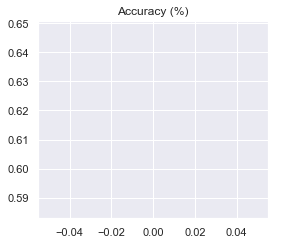

step: 10


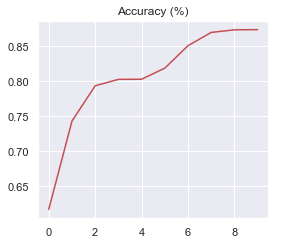

END: BELOW THRESHOLD
step: 14


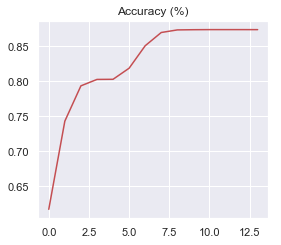

accuracy: 0.8738833333333333
-----DMEANS: 0.001000-----
step: 1


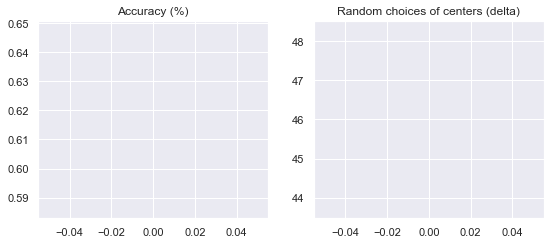

step: 10


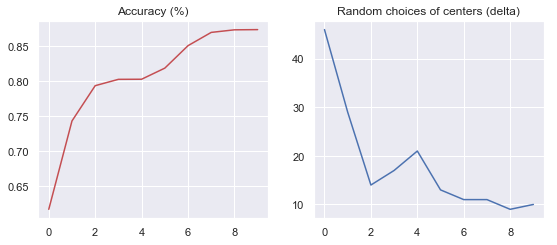

END: BELOW THRESHOLD
step: 15


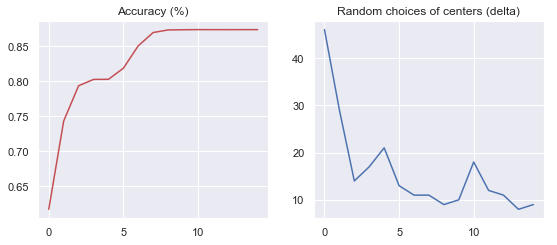

accuracy: 0.8738833333333333
-----DMEANS: 0.010000-----
step: 1


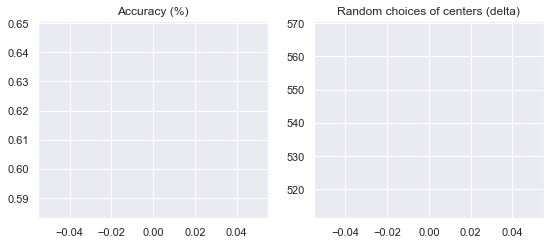

step: 10


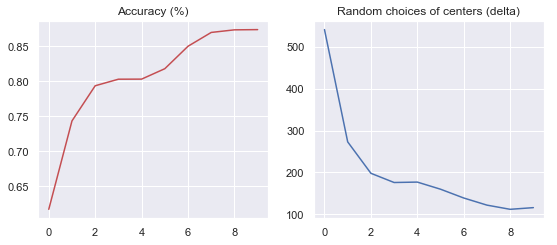

step: 20


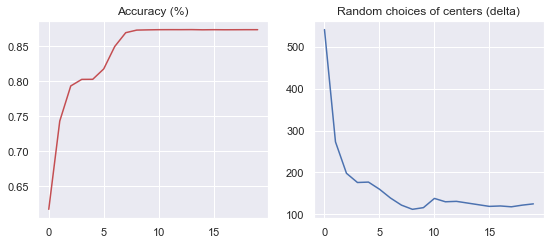

step: 30


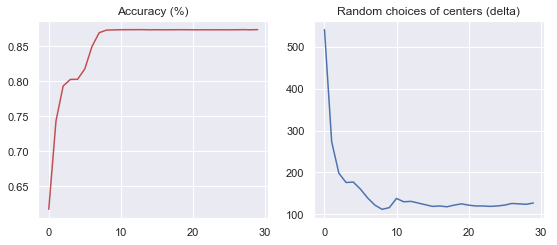

END: BELOW THRESHOLD
step: 31


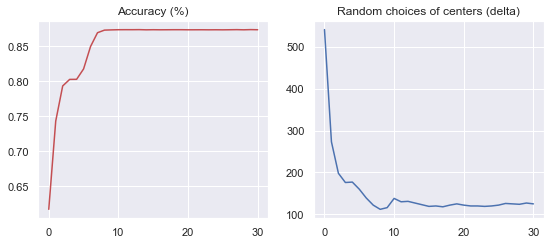

accuracy: 0.8738333333333334
-----DMEANS: 0.100000-----
step: 1


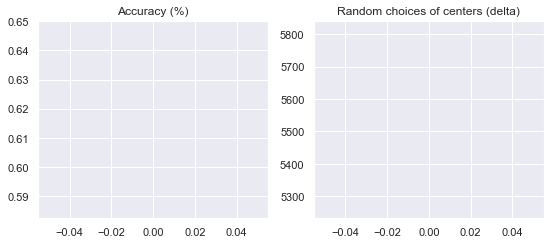

step: 10


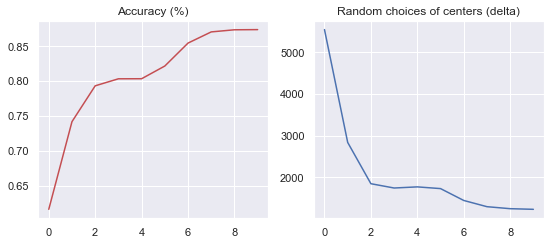

step: 20


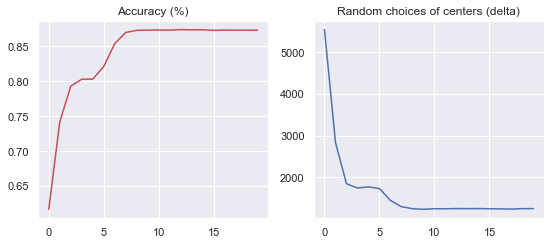

step: 30


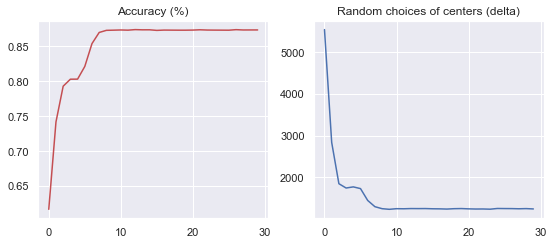

END: BELOW THRESHOLD
step: 38


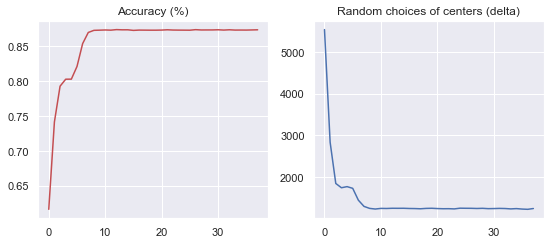

accuracy: 0.8738
-----DMEANS: 0.500000-----
step: 1


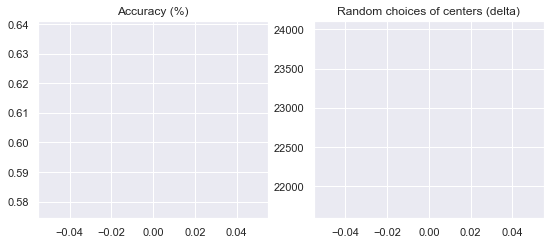

step: 10


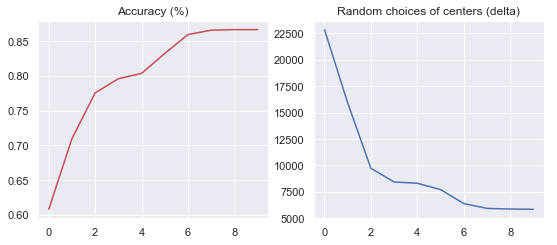

step: 20


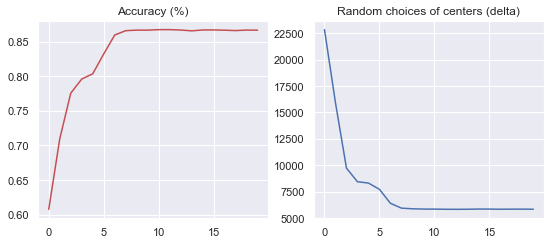

END: BELOW THRESHOLD
step: 28


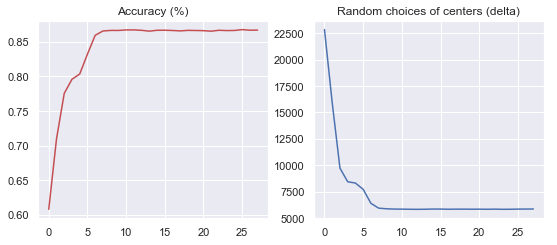

accuracy: 0.8669666666666667


In [122]:
dataset = X_


print("-----KMEANS-----")
_,_, accuracy_regular = find_clusters_regular(dataset, n_clusters=10, threshold=0.01)

deltas = [0.001,0.01,0.1,0.5]
accuracy_deltas = []
for delta in deltas:
    print("-----DMEANS: %f-----"%delta)
    _,_,_,accuracy = find_clusters_delta(dataset, n_clusters=10, delta=delta, threshold=0.01)
    accuracy_deltas.append(accuracy)



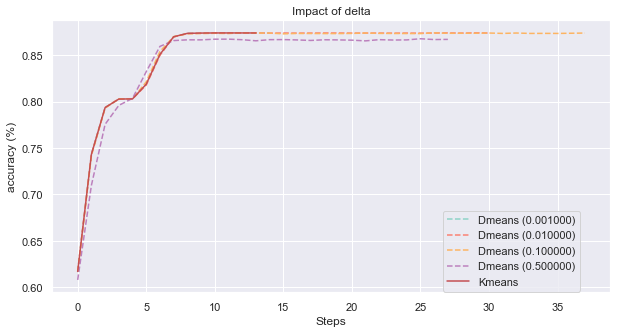

In [128]:
import matplotlib.cm as cm
color = cm.Set3(np.random.rand(len(deltas)))
plt.figure(figsize=(10,5))

for j in range(len(deltas)):
    plt.plot(accuracy_deltas[j], c=color[j], label="Dmeans (%f)"%deltas[j],linestyle='--')
    
plt.plot(accuracy_regular, 'r', label="Kmeans")


plt.title("Impact of delta")
plt.xlabel("Steps")
plt.ylabel("accuracy (%)")
plt.legend(bbox_to_anchor=(0.7, 0.3), loc=2, borderaxespad=0.)
plt.show()